# 03_model_training.ipynb


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import joblib

# Load cleaned data


In [16]:
df = pd.read_csv('../data/deliverytime_cleaned.csv')

# Use log_distance instead of distance_km if both exist


In [17]:
if 'log_distance' in df.columns and 'distance_km' in df.columns:
    df.drop('distance_km', axis=1, inplace=True)

# Define features and target


In [18]:
X = df.drop('Time_taken(min)', axis=1)
y = df['Time_taken(min)']

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print("\nFeature Scores:")
print(feature_scores.sort_values(by='Score', ascending=False))


Feature Scores:
                   Feature         Score
6           speed_estimate  16684.106348
1  Delivery_person_Ratings   5613.498577
0      Delivery_person_Age   4272.171350
4             log_distance   2335.166508
7             age_x_rating   1220.601709
5        distance_x_rating   1144.234793
3  Type_of_vehicle_encoded    297.907313
2    Type_of_order_encoded      0.369546


# Split into train and test sets


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features


In [20]:
scaler = StandardScaler()
pca = PCA(n_components=0.95)

# Define base models

In [21]:
base_models = [
    ('lr', Ridge()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42))
]

# Define models


In [22]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'HistGB': HistGradientBoostingRegressor(random_state=42),
    'Stacking': StackingRegressor(estimators=base_models, final_estimator=Ridge())
}

# Train and evaluate models


In [23]:
results = {}

for name, model in models.items():
    if name in ['HistGB']:
        pipe = Pipeline([
            ('regressor', model)
        ])
    else:
        pipe = Pipeline([
            ('scaler', scaler),
            ('pca', pca),
            ('regressor', model)
        ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Show evaluation results


In [24]:
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print("\nModel Performance:")
display(results_df)# Plot prediction vs actual for best model


Model Performance:


,MAE,RMSE,R2
HistGB,0.205899,0.479907,0.997373
Stacking,1.281301,1.951455,0.956566
Random Forest,1.340526,2.156801,0.946945
XGBoost,1.598429,2.299783,0.939677
Linear Regression,6.122665,7.870430,0.293511


# Hyperparameter tuning for best model (XGBoost)


In [25]:
print("\nTuning XGBoost with GridSearchCV...")
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regressor', XGBRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_


Tuning XGBoost with GridSearchCV...
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 200}


# Cross-validation score


In [26]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Cross-validated R²:", cv_scores.mean())

Cross-validated R²: 0.8367841005325317


# Plot prediction vs actual for best model


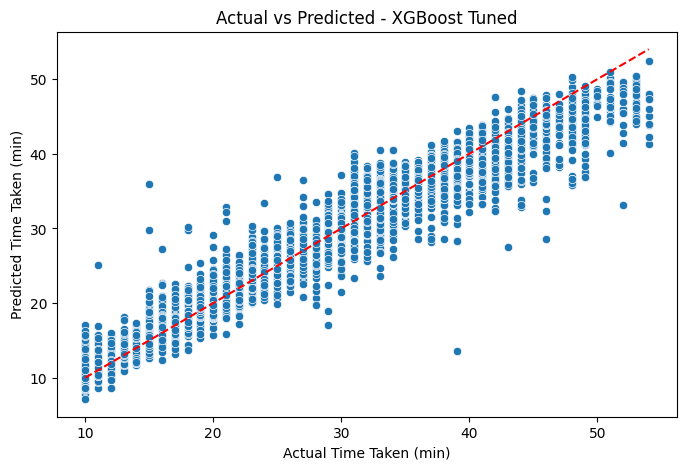

In [ ]:
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Time Taken (min)')
plt.ylabel('Predicted Time Taken (min)')
plt.title('Actual vs Predicted - XGBoost Tuned')
plt.savefig('../reports/images/model/Actual_vs_Predicted_XGBoost_Tuned.png', dpi=100)
plt.show()

# Save the best model


In [28]:
joblib.dump(best_model, '../models/best_model.pkl')

['../models/best_model.pkl']